# Emergency Vehicle Identification using CNN

In [17]:
#importing dependencies
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os
import itertools

In [2]:
#image paths
train_path = 'images/train'
val_path = 'images/val'
test_path = 'images/test'

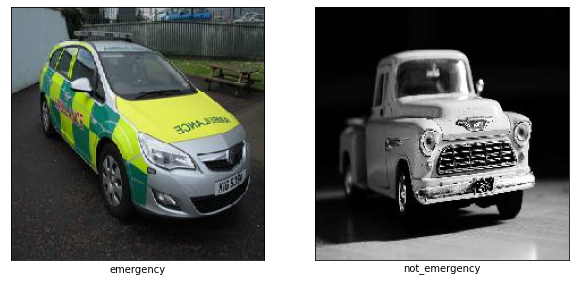

In [56]:
#view sample images
emergency_vehicle ='images/train/emergency/0.jpg'
not_emergency_vehicle = 'images/train/not_emergency/1002.jpg'

plt.rcParams["figure.figsize"] = (10,5)
for idx, path in enumerate([emergency_vehicle,not_emergency_vehicle]):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, idx+1)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(path.split('/')[2])
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])

In [13]:
#image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [84]:
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        directory=val_path,
        target_size=(150, 150),
        batch_size=32,
        shuffle=False,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(150, 150),
        #batch_size=32,
        shuffle=False,
        class_mode=None)

Found 1646 images belonging to 2 classes.
Found 706 images belonging to 2 classes.
Found 15 images belonging to 1 classes.


In [15]:
train_generator.class_indices

{'emergency': 0, 'not_emergency': 1}

# Model Training

In [18]:
#Call back setup
mc = ModelCheckpoint(filepath='./base_model.h5',
                     monitor='accuracy',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor='accuracy',
                   min_delta=0.01,
                   patience=5,
                   verbose=1)
cb = [mc,es]

# Custom model

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [27]:
history = model.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=cb)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.5192 - accuracy: 0.5563
Epoch 1: accuracy did not improve from 0.81126
10/10 [==============================] - 12s 998ms/step - loss: 1.5192 - accuracy: 0.5563
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5662
Epoch 2: accuracy did not improve from 0.81126
10/10 [==============================] - 15s 1s/step - loss: 0.6856 - accuracy: 0.5662
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.6250
Epoch 3: accuracy did not improve from 0.81126
10/10 [==============================] - 13s 1s/step - loss: 0.6712 - accuracy: 0.6250
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.6875
Epoch 4: accuracy did not improve from 0.81126
10/10 [==============================] - 11s 1s/step - loss: 0.6272 - accuracy: 0.6875
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 0.5766 - accuracy

In [30]:
model = load_model('base_model.h5')
loss, accuracy = model.evaluate(validation_generator)
print(f'loss:{loss}')
print(f'accuracy:{accuracy}')

23/23 [==============================] - 5s 210ms/step - loss: 0.4942 - accuracy: 0.7564
loss:0.4941530227661133
accuracy:0.756373941898346


# Transfer learning

In [36]:
vgg = VGG16(input_shape = (150,150,3), weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False
    
x = layers.Flatten()(vgg.output)
x = layers.Dense(1024, activation = 'relu')(x) 
x = layers.Dense(2, activation='softmax')(x)

model2 = Model(inputs = vgg.input, outputs = x)

In [37]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [38]:
history2 = model2.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=cb)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 3.7912 - accuracy: 0.4969
Epoch 1: accuracy did not improve from 0.81126
10/10 [==============================] - 41s 4s/step - loss: 3.7912 - accuracy: 0.4969
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.6689
Epoch 2: accuracy did not improve from 0.81126
10/10 [==============================] - 40s 4s/step - loss: 0.7491 - accuracy: 0.6689
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8156
Epoch 3: accuracy improved from 0.81126 to 0.81563, saving model to .\base_model.h5
10/10 [==============================] - 44s 4s/step - loss: 0.3852 - accuracy: 0.8156
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8219
Epoch 4: accuracy improved from 0.81563 to 0.82187, saving model to .\base_model.h5
10/10 [==============================] - 43s 4s/step - loss: 0.4066 - accuracy: 0.8219
Epoch 5/20
10/

In [39]:
model2 = load_model('base_model.h5')
loss, accuracy = model2.evaluate(validation_generator)
print(f'loss:{loss}')
print(f'accuracy:{accuracy}')

23/23 [==============================] - 86s 4s/step - loss: 0.2302 - accuracy: 0.9051
loss:0.23018282651901245
accuracy:0.9050991535186768


# Model evaluation

In [40]:
#confusion matrix plot function 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `noramlize=True`
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without Normalized')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
labels = list(train_generator.class_indices.keys())
labels

['emergency', 'not_emergency']

In [42]:
#custom model prediction
predictions = model.predict(x=validation_generator, verbose=0)
predictions = np.argmax(predictions, axis=1)

In [43]:
#vgg16 model prediction
predictions2 = model2.predict(x=validation_generator, verbose=0)
predictions2 = np.argmax(predictions2, axis=1)

In [44]:
#confusion matrix
cm =confusion_matrix(validation_generator.classes, predictions)
cm2 =confusion_matrix(validation_generator.classes, predictions2)

In [45]:
train_generator.class_indices

{'emergency': 0, 'not_emergency': 1}

confusion matrix, without Normalized
[[225  85]
 [ 87 309]]


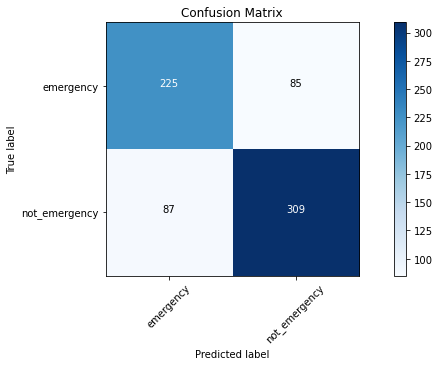

In [59]:
#plot confusion matrix for custom model
plot_confusion_matrix(cm=cm, classes=labels)

confusion matrix, without Normalized
[[277  33]
 [ 34 362]]


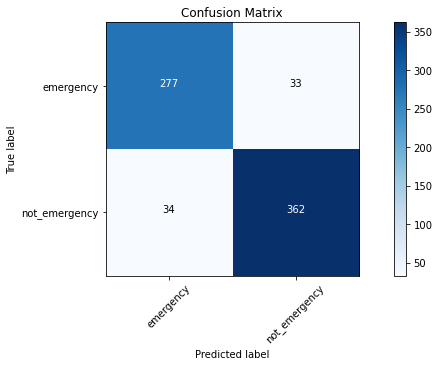

In [60]:
#plot confusion matrix for vgg16 model
plot_confusion_matrix(cm=cm2, classes=labels)

# Model testing

In [86]:
images = next(test_generator)

ValueError: in user code:

    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 200, 3)


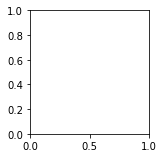

In [83]:
plt.rcParams["figure.figsize"] = (20,5)
for idx, img in enumerate(images):
    plt.subplot(2, 8, idx+1)
    pred = model.predict(img)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(f'prediction:{labels[np.argmax(pred, axis=1)]}')
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])

In [95]:
pred = model.predict(images[0])

ValueError: in user code:

    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 150, 3)


In [91]:
images[0].shape

(150, 150, 3)

In [93]:
pred

array([[0.9256961 , 0.07430395],
       [0.00523412, 0.9947659 ],
       [0.6508286 , 0.3491714 ],
       [0.12027965, 0.8797204 ],
       [0.07872459, 0.92127544],
       [0.38278398, 0.61721605],
       [0.15073527, 0.84926474],
       [0.33874005, 0.66126   ],
       [0.5887746 , 0.4112253 ],
       [0.21998096, 0.78001904],
       [0.5355021 , 0.46449792],
       [0.8778863 , 0.12211373],
       [0.53893346, 0.46106654],
       [0.67188895, 0.32811105],
       [0.8071474 , 0.19285257]], dtype=float32)